In [1]:
from wawi.io import import_folder
import numpy as np
from wawi.model import Windstate
import matplotlib.pyplot as plt

In [2]:
# Import model
model = import_folder('./model_two_sections')
model.modal_dry.xi0 = .5e-2

Valid pontoon data not found. No pontoons created.
Valid pontoon types file not found. No pontoon_types definitions applied.
Specified drag_elements file found or invalid. No drag elements defined.


In [3]:
# Define windstate and plot model
V0 = 40.0
model.aero.windstate = Windstate(V0, 
                                 45, 
                                 Iu=2.0/V0, 
                                 Iw=1.0/V0, 
                                 Au=30, Aw=3, 
                                 Cuy=10.0, Cwy=8.0,
                                 Cuz=10.0, Cwz=8.0,
                                 Lux=60, Lwx=60,
                                 x_ref=[0,0,0], rho=1.25)

model.n_modes = 50

model.plot(tmat_on=['undeformed'])

Widget(value="<iframe src='http://localhost:55574/index.html?ui=P_0x29eb1aab190_0&reconnect=auto' style='width…

In [4]:
# Run eigenvalue solution and plot resulting first mode
model.run_eig(aero_sections=['girder'])

mode = 1
model.plot_mode(mode, use_dry=False, title=f'Mode {mode+1}: {model.results.xi[mode]*100:.4f}%')

[ >>>>>>>>>>>>>>>>>>>> ] 101% finished with iterative modal analysis. 


Widget(value="<iframe src='http://localhost:55574/index.html?ui=P_0x29eb30a9a50_1&reconnect=auto' style='width…

In [5]:
# Run frequency-domain analysis
omega = np.linspace(0.00001, 6, 1000)

# girder1 + girder2 with merging
model.run_freqsim(omega,
                  include_selfexcited=['aero'], 
                  include_action=['aero'],
                  print_progress=False, merge_aero_sections=True, aero_sections=['girder1', 'girder2'])

# girder only (includes all elements in both girder1 and girder2), equivalent to girder1+girder2 w/merging
model2 = model.copy()
model2.run_freqsim(omega,
                  include_selfexcited=['aero'], 
                  include_action=['aero'],
                  print_progress=False, merge_aero_sections=True, aero_sections=['girder']) 

# girder1 + girder2 without merging (action treated independently --> no coherence) - should deviate slightly
model3 = model.copy()
model3.run_freqsim(omega,
                  include_selfexcited=['aero'], 
                  include_action=['aero'],
                  print_progress=False, merge_aero_sections=False, aero_sections=['girder1', 'girder2']) 

Local nodal csys is strictly not possible - averaging introduced (use with care).
Local nodal csys is strictly not possible - averaging introduced (use with care).
Local nodal csys is strictly not possible - averaging introduced (use with care).


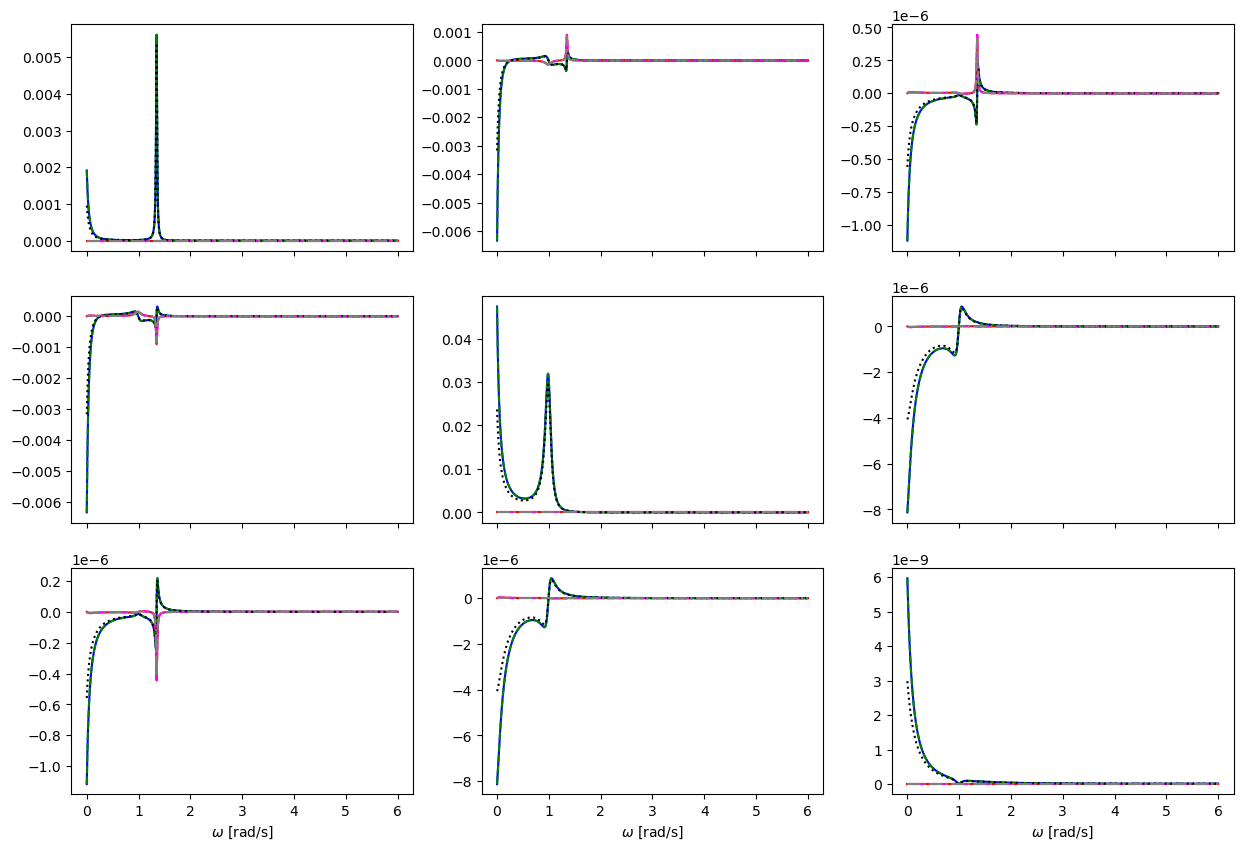

In [7]:
# Output physical CPSD
plot_dofs = np.array([1,2,3])
node_ix = 50
global_dof_ix = node_ix*6+plot_dofs

S1 = model.get_result_psd(key='full', 
                         index=global_dof_ix,
                         convert_to='local')
S2 = model2.get_result_psd(key='full', 
                         index=global_dof_ix,
                         convert_to='local')
S3 = model3.get_result_psd(key='full', 
                         index=global_dof_ix,
                         convert_to='local')

fig,ax = plt.subplots(nrows=S1.shape[0], ncols=S1.shape[1], figsize=(15,10), sharex=True)
for i in range(S1.shape[0]):
    for j in range(S1.shape[1]):
        ax[i,j].plot(model.results.omega, S1[i,j,:].real, color='blue')
        ax[i,j].plot(model.results.omega, S1[i,j,:].imag, color='red')
        
        ax[i,j].plot(model.results.omega, S2[i,j,:].real, color='green', linestyle='--')
        ax[i,j].plot(model.results.omega, S2[i,j,:].imag, color='magenta', linestyle='--')
        
        ax[i,j].plot(model.results.omega, S3[i,j,:].real, color='black', linestyle=':') #plotting only real part
        ax[i,j].plot(model.results.omega, S3[i,j,:].imag, color='gray', linestyle='-.') #plotting only real part
    ax[-1,i].set_xlabel('$\omega$ [rad/s]')